## Test Data Generation
This notebook contains some simple funtions to generate two different distributions of test data for CANOSP 2019

Currently there are two types of data generation:
    - `Blob` generation (data clustered around a point)
    - `Random` (no correlation)

A few functions have been created to generate samples that:
    - Contains N features
    - Contain M labels (species)
    
Finally, note that the format of the DataFrame returned by the generation functions is like this:

```
data_point_1_feat_1 data_point_1_feat_2, ...
data_point_2_feat_1 data_point_2_feat_2, ...
...
```

In [1]:
# Likely not needed...
%matplotlib inline

import random_data_gen as rdata_gen
import pandas as pd

### Graph params
Adjust these to control the paraeters used to generate the example graphs. Does not affect the function defs!

In [19]:
NUM_SAMPLES = 20000
NUM_LABELS = 3
NUM_FEATURES = 4
NUM_USERS = 100

# Used to control the range of values for the random gen func (1.0 --> [-1.0, 1.0])
RAND_FEAT_RANGE = 1.0
USERS_MIN_UNIQUE_LABELS = 2

CSV_FILE_NAME_TEMPLATE = "{}_S{}_L{}_F{}_U{}.csv" # Type(Rand/Blob)_S#samples_L#labels_F#features_U#users.csv
CSV_DATASET_DIR = "datasets"

# Put into a nice package to pass around
g_prms = rdata_gen.InputGenParams(NUM_SAMPLES, NUM_LABELS, NUM_FEATURES, NUM_USERS)

### Graphs
Just to visualize that the generation is doing it's job, we just threw together some scatterplot matrices.

Note that for whatever reason, assigning unique colours to species is not enabled by default, and it appears to be some work to have the matrix scatter plots use any different colours for different species. So for now, we're just settling for mono-colour plots. :)

In [3]:
def plot_scatter_matrix(data):
    '''
    Just wrap the call to improve readability niceness :)
    '''
    pd.plotting.scatter_matrix(data, alpha=0.2, figsize=(10, 10))

#### Blob Plot
Visualizaton of blob generation

In [4]:
data = rdata_gen.generate_blob_data(g_prms)

/home/brendan/School_Stuff/CMPUT_496/CANOSP-2019/random_data_gen.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field_name] = new_field


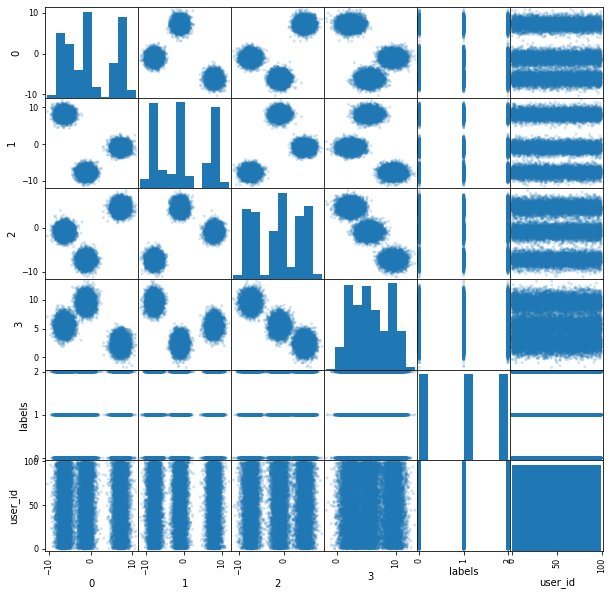

In [9]:
plot_scatter_matrix(data)

#### Random Plot

In [5]:
data = rdata_gen.generate_random_data(g_prms)

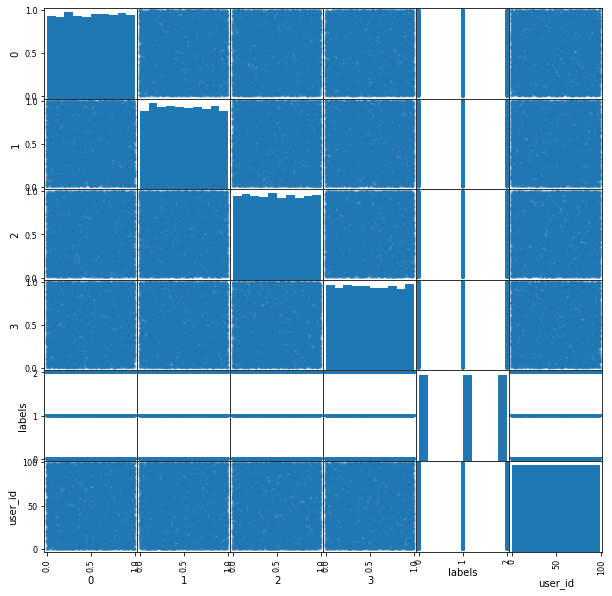

In [12]:
plot_scatter_matrix(data)

### Formating Data for Simulator Consumption
While the current format of data is very nice for working with graphs, it may be a bit over complicated for working with directly. Here we transform the format into something more digestable for the simulator.

In [6]:
def transform_data_for_simulator_format(data):
    labels = []
    feats = []
    for i in range(NUM_USERS):
        client_df = df[df.user_id == i]
        labels.append(list(client_df.labels))
        client_feats = client_df.drop(columns=["user_id", "labels"]).to_records(index=False)
        feats.append(list(client_feats))
        
    return (labels, feats)

#### Example of How to Call the Transform Function

In [7]:
df = rdata_gen.generate_blob_data(g_prms)
labels, feats = transform_data_for_simulator_format(df)

### Generating csv Data from the Generated Data
Since it's easier to move to csv from a Pandas DataFrame, the workflow should look like this:

In [20]:
GEN_TYPE_RAND = 0
GEN_TYPE_BLOB = 1

gen_type_name_ltable = ["rand", "blob"]

def gen_csv_filename(g_prms, gen_type):
    gen_type_name = gen_type_name_ltable[gen_type]
    return CSV_FILE_NAME_TEMPLATE.format(gen_type_name,
                                              g_prms.num_samples,
                                              g_prms.num_labels,
                                              g_prms.num_features,
                                              g_prms.num_users)

def write_csv_to_file(file_name):
    csv_data.to_csv(file_name, index=False)

In [21]:
# Generate your data:
data = rdata_gen.generate_blob_data(g_prms)

In [22]:
# Write to file:
file_name = gen_csv_filename(g_prms, GEN_TYPE_BLOB)
csv_data = data.to_csv("{}/{}".format(CSV_DATASET_DIR, file_name))

In [23]:
# Read the file back in from disk:
df = pd.read_csv(file_name)

In [24]:
# And if plugging back into the simulator then transform the data to a usable format:
sim_labels, sim_feats = rdata_gen.transform_data_for_simulator_format(df, g_prms)

### Unused Funcs

#### gen_clustered_data
Initially we tried using the make_classification function to generate clustered data. However, it became difficult to scale with different inputs since, internally, it has restraints on what `n_informative` can be set to depending on what other paremeters are set. In the end, we opted for blob generation mostly because it was simplier to use and did what we wanted to. However, later on we may want to revist this function if we find we need to test with different distributions of data as `make_classification` allows for more control.

In [25]:
def gen_clustered_data(tot_samples, num_labels, num_features):
    (feat_val_arrs, feat_idxs) = datasets.make_classification(n_samples=TOT_SAMPLES,
                                                         n_features=NUM_FEATURES,
                                                         n_classes=NUM_LABELS,
                                                         n_redundant=0,
                                                         n_repeated=0,
                                                         class_sep=0.5)
    df = pd.DataFrame(feat_val_arrs)
    df['labels'] = feat_idxs
        
    return df

#### gen_hist_of_features
Just an attempt to manually generate overlaping histograms for each species. (Defaults to using separate colours for each overlapping histogram, how about that!). The scatter matrix automatically generates a histogram on the diagonal, so this is kind of no longer needed.

In [26]:
def gen_hist_of_features(df):
    thing = df.pivot(columns='labels', values=0)
    pyplot.hist(thing, alpha=0.5)

    pyplot.legend(loc='upper right')
    pyplot.show()